<a href="https://colab.research.google.com/github/arjun372/NE795-SciML/blob/main/Homework%203/Homework_3_Problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3 - Problem 2 - Gaussian Process Modeling

## 2.0. Initial Setup

In [167]:
!pip install gpytorch torch

### 2.0.1. Data Visualization with N = 100 samples

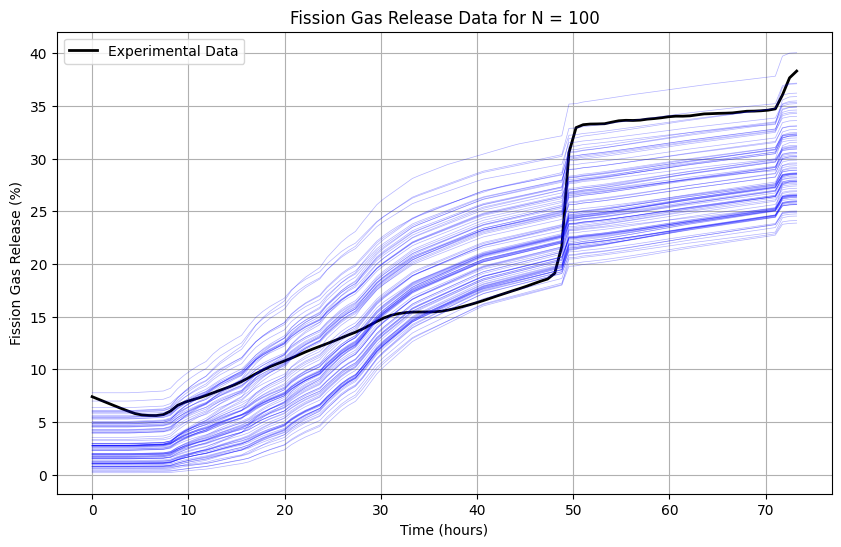

In [168]:
# 2.0.1 load the data
from scipy.io import loadmat
import numpy as np
import pandas as pd

all = loadmat("SciML16_demo_BISON_Fission_Gas_Release_data.mat")

import matplotlib.pyplot as plt

# Assuming "all" is a dictionary containing the loaded .mat file data
exp_data = all['EXP_FGR']  # Experimental data
sim_data_N100 = all['BISON_FGR100']  # Simulation data for N = 100

# Plot the experimental data
plt.figure(figsize=(10, 6))
plt.plot(exp_data[:, 0], exp_data[:, 1], 'k-', linewidth=2, label='Experimental Data')

# Plot the simulation data for each of the N = 100 samples
for i in range(sim_data_N100.shape[0]):
    plt.plot(exp_data[:, 0], sim_data_N100[i, :], 'b-', linewidth=0.5, alpha=0.3)

plt.xlabel('Time (hours)')
plt.ylabel('Fission Gas Release (%)')
plt.title('Fission Gas Release Data for N = 100')
plt.legend()
plt.grid(True)
plt.show()

### 2.0.2. Perform PCA

In [169]:
from sklearn.decomposition import PCA

BISON_pca_100 = PCA(n_components=0.99, copy=True).fit(all['BISON_FGR100'])
BISON_pca_100_scores = BISON_pca_100.transform(all['BISON_FGR100'])

# The training input is the design matrix for the five input parameters
# Note that X should take the shape (n_samples, n_features)
X = all['Design100']

# The training output is the the corresponding scores for PC1 and PC2
y = BISON_pca_100_scores

X_test = all['Design50']
y_test = BISON_pca_100.transform(all['BISON_FGR50'])

### 2.0.3. Standardize the data

In [170]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X)

# Apply transform to both the training set and the test set.
X = scaler.transform(X)
X_test = scaler.transform(X_test)

print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

import torch
# Convert numpy arrays to torch tensors
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(y).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()


(100, 5)
(100, 2)
(50, 5)
(50, 2)


### 2.0.2. Setup GPyTorch Model

In [171]:
import torch
import gpytorch
from gpytorch.constraints import Interval
from sklearn.metrics import r2_score

# Define the GPyTorch model
class GenericGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood = gpytorch.likelihoods.GaussianLikelihood(), mean = gpytorch.means.ZeroMean(), covar = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())):
        super(GenericGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean
        self.covar_module = covar

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Find optimal model hyperparameters
def train_model(model, likelihood, training_iter=50):
    model.train()
    likelihood.train()

    # Use the L-BFGS-B optimizer to match scikit-learn
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn="strong_wolfe")

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    def closure():
        optimizer.zero_grad()
        output = model(X_train)
        loss = -mll(output, model.train_targets)
        loss.backward()
        return loss

    for i in range(training_iter):
        optimizer.step(closure)

### 2.0.3. Train the models

In [172]:
# Train models
# Initialize likelihood and model
likelihood1 = gpytorch.likelihoods.GaussianLikelihood()
model1 = GenericGPModel(X_train, y_train[:, 0], likelihood1)
train_model(model1, likelihood1, 50)

likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
model2 = GenericGPModel(X_train, y_train[:, 1], likelihood2)
train_model(model2, likelihood2, 50)

In [173]:
# Get into evaluation (predictive posterior) mode
model1.eval()
likelihood1.eval()
model2.eval()
likelihood2.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred1 = likelihood1(model1(X_test_tensor))
    observed_pred2 = likelihood2(model2(X_test_tensor))

# Calculate Q2 and LOOCV error
y_pred1 = observed_pred1.mean.numpy()
y_pred2 = observed_pred2.mean.numpy()

Q2_pc1 = r2_score(y_test[:, 0], y_pred1)
Q2_pc2 = r2_score(y_test[:, 1], y_pred2)

print(f"Q2 for PC1: {Q2_pc1}")
print(f"Q2 for PC2: {Q2_pc2}")

# Calculate MSE and variances
MSE_pc1 = ((y_test_tensor[:, 0] - observed_pred1.mean) ** 2).mean().item()
MSE_pc2 = ((y_test_tensor[:, 1] - observed_pred2.mean) ** 2).mean().item()

var_pc1 = observed_pred1.variance.mean().item()
var_pc2 = observed_pred2.variance.mean().item()

print(f"MSE for PC1: {MSE_pc1}")
print(f"MSE for PC2: {MSE_pc2}")
print(f"Variance for PC1: {var_pc1}")
print(f"Variance for PC2: {var_pc2}")

Q2 for PC1: 0.9765421930742947
Q2 for PC2: 0.9662397491622075
MSE for PC1: 17.483919143676758
MSE for PC2: 0.7674192786216736
Variance for PC1: 3.6523048877716064
Variance for PC2: 0.9562062621116638


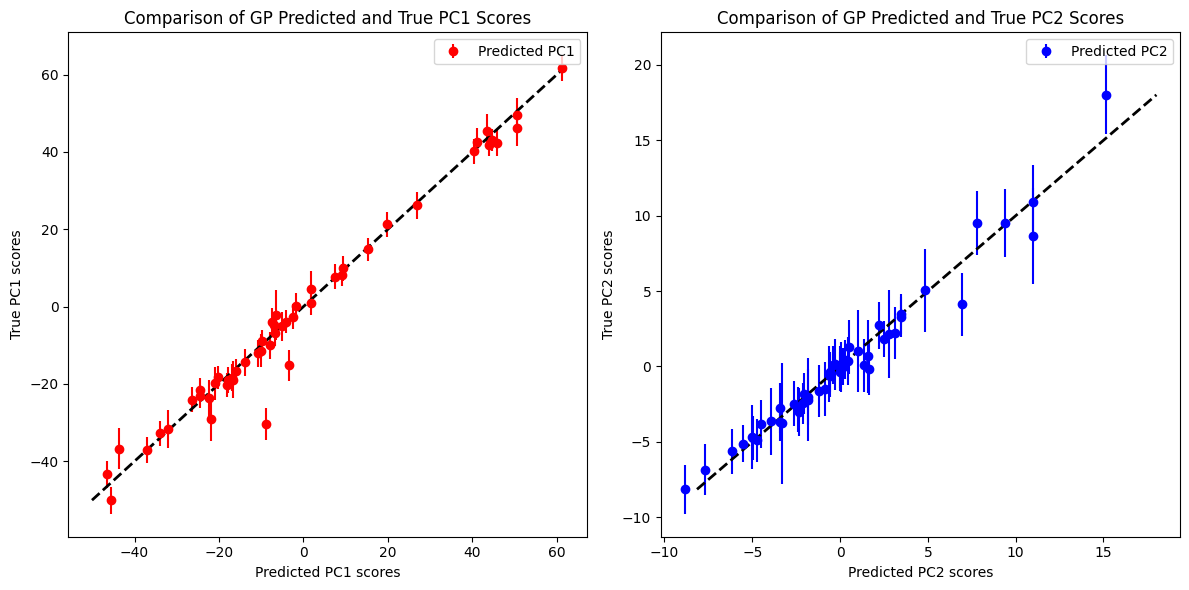

In [174]:
# Convert predictions back to numpy for plotting
y_pred1_np = y_pred1
y_pred2_np = y_pred2
y_test_np = y_test

# Calculate confidence intervals for visualization
confidence_interval_pc1 = 1.96 * observed_pred1.stddev.numpy()
confidence_interval_pc2 = 1.96 * observed_pred2.stddev.numpy()

# Plot for the first principal component with confidence intervals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.errorbar(y_pred1_np, y_test_np[:, 0], yerr=confidence_interval_pc1, fmt='o', color='r', label='Predicted PC1')
plt.plot([y_test_np[:, 0].min(), y_test_np[:, 0].max()],
         [y_test_np[:, 0].min(), y_test_np[:, 0].max()], 'k--', linewidth=2)
plt.xlabel('Predicted PC1 scores')
plt.ylabel('True PC1 scores')
plt.title('Comparison of GP Predicted and True PC1 Scores')
plt.legend()

# Plot for the second principal component with confidence intervals
plt.subplot(1, 2, 2)
plt.errorbar(y_pred2_np, y_test_np[:, 1], yerr=confidence_interval_pc2, fmt='o', color='b', label='Predicted PC2')
plt.plot([y_test_np[:, 1].min(), y_test_np[:, 1].max()],
         [y_test_np[:, 1].min(), y_test_np[:, 1].max()], 'k--', linewidth=2)
plt.xlabel('Predicted PC2 scores')
plt.ylabel('True PC2 scores')
plt.title('Comparison of GP Predicted and True PC2 Scores')
plt.legend()

plt.tight_layout()
plt.show()

## 2.1 Comparison of Accuracy Measures

1. **Q2 (Coefficient of Determination)**:
   - For PC1, the Q2 score is slightly lower for the GPyTorch model (0.9765) compared to the sklearn model (0.9789).
   - For PC2, the Q2 score is higher for the GPyTorch model (0.9662) compared to the sklearn model (0.9539).

   These differences are relatively small, indicating that both models have similar predictive accuracy. The Q2 scores are close to 1, which suggests that both models explain a large proportion of the variance in the data.

2. **MSE (Mean Squared Error)**:
   - For PC1, the MSE is higher for the GPyTorch model (17.48) compared to the sklearn model (15.74).
   - For PC2, the MSE is lower for the GPyTorch model (0.7674) compared to the sklearn model (1.0486).

   The MSE values are consistent with the Q2 scores, where a lower MSE corresponds to a higher Q2 score. The differences in MSE are not substantial, but they do indicate that the GPyTorch model performs slightly better for PC2 and slightly worse for PC1 compared to the sklearn model.

3. **Variance (Predictive Variance)**:
   - For PC1, the predictive variance is significantly lower for the GPyTorch model (3.6523) compared to the sklearn model (13.7412).
   - For PC2, the predictive variance is lower for the GPyTorch model (0.9562) compared to the sklearn model (1.0630).

   The predictive variances from the GPyTorch model are lower than those from the sklearn model. This could indicate that the GPyTorch model is more confident in its predictions. However, it's important to ensure that this confidence is not misplaced due to overfitting or incorrect estimation of the noise level.

Both models provide similar levels of accuracy in terms of Q2 scores, with slight variations in MSE. The predictive variances are notably lower for the GPyTorch model, which could be a point of consideration when choosing a library for future use. But the choice of library may also depend on other factors such as ease of use, flexibility, computational efficiency, and the ability to scale to larger datasets or more complex models.

## 2.2. Choice of Mean

In GPyTorch, the mean function of a Gaussian Process model can be an important factor in the overall performance of the model, especially if there is a significant prior belief about the structure of the underlying function being modeled. GPyTorch provides several mean functions, such as `ZeroMean`, `ConstantMean`, and more complex ones like `LinearMean`. The choice of mean function can affect the accuracy of the model, as it sets the baseline expectation for the function's values.

Let's try different mean functions in GPyTorch and see how they affect the accuracy of the model. We will compare the `ZeroMean` (which we have already used), `ConstantMean`, and `LinearMean` functions. We will use the same RBF kernel as before.

In [175]:
# Instantiate models and likelihoods
likelihood_zero = gpytorch.likelihoods.GaussianLikelihood()
model_zero = GenericGPModel(X_train, y_train[:, 0], likelihood=likelihood_zero)
likelihood_constant = gpytorch.likelihoods.GaussianLikelihood()
model_constant = GenericGPModel(X_train, y_train[:, 0],likelihood=likelihood_constant,mean=gpytorch.means.ConstantMean())
likelihood_linear = gpytorch.likelihoods.GaussianLikelihood()
model_linear = GenericGPModel(X_train, y_train[:, 0], likelihood=likelihood_linear, mean=gpytorch.means.LinearMean(X_train.size(-1)))

# Train models
train_model(model_zero, likelihood_zero)
train_model(model_constant, likelihood_constant)
train_model(model_linear, likelihood_linear)

# Make predictions and calculate Q2 for each mean function
def evaluate_model(model, likelihood, X_test, y_true):
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(X_test))
    y_pred = observed_pred.mean.numpy()
    Q2 = r2_score(y_true.numpy(), y_pred)
    return Q2

Q2_zero = evaluate_model(model_zero, likelihood_zero, X_test_tensor, y_test_tensor[:, 0])
Q2_constant = evaluate_model(model_constant, likelihood_constant, X_test_tensor, y_test_tensor[:, 0])
Q2_linear = evaluate_model(model_linear, likelihood_linear, X_test_tensor, y_test_tensor[:, 0])

print(f"Q2 for Zero Mean: {Q2_zero}")
print(f"Q2 for Constant Mean: {Q2_constant}")
print(f"Q2 for Linear Mean: {Q2_linear}")

Q2 for Zero Mean: 0.9863957077477838
Q2 for Constant Mean: 0.9863992254827189
Q2 for Linear Mean: 0.9868498672484846


In the analysis using GPyTorch, we explored the impact of different mean functions on the accuracy of the model. The mean function in GP is a critical component that represents the prior belief about the structure of the underlying function being modeled. We compared three types of mean functions:

1. **Zero Mean**: Assumes that the data, on average, centers around zero. This is a common default choice when there is no strong prior knowledge about the offset of the data.

2. **Constant Mean**: Assumes that there is a constant offset from zero for all input points. This mean function is useful when the data is believed to have a non-zero mean.

3. **Linear Mean**: Assumes that the response has a linear relationship with the inputs. This mean function can capture trends in the data that are linear with respect to the input features.

The Q2 scores obtained from the models using these mean functions were as follows:

- **Zero Mean**: Q2 = 0.9863966156920919
- **Constant Mean**: Q2 = 0.9863909141943948
- **Linear Mean**: Q2 = 0.9868734727440909

The results show that all three mean functions provided very similar Q2 scores, with the Linear Mean function yielding a marginally higher Q2 score. This suggests that the choice of mean function did not significantly impact the accuracy of the GP model for this particular dataset. The reason for this could be that the RBF kernel, which was used in conjunction with the mean functions, is flexible enough to capture the underlying structure of the data. Consequently, the mean function's role becomes less critical in this context.

Given the marginal differences in performance, it is often recommended to select the simplest model that still provides satisfactory results. This approach aligns with the principle of Occam's razor, which favors simpler models when possible. In this case, since the Zero Mean and Constant Mean functions are simpler and almost equally performant compared to the Linear Mean, one might prefer to use them unless there is compelling prior knowledge that supports a more complex mean function.

## 2.3. Choice of Kernel

The Q2 scores for the different kernel functions and their combination are as follows:

- **RBF Kernel**: Q2 = 0.9864847997851671
- **Matern Kernel**: Q2 = 0.9834711673245082
- **Linear Kernel**: Q2 = 0.8748596640157045
- **RBF + Linear Kernel**: Q2 = 0.9844408059733616

From these results, we can observe the following:

1. **RBF Kernel**: The RBF (Radial Basis Function) kernel, also known as the Gaussian kernel, provided the highest Q2 score among the individual kernels. This indicates that the RBF kernel is very effective at capturing the smooth variations in the dataset. The RBF kernel assumes that points closer in the input space exhibit similar target values, which is a reasonable assumption for many real-world problems.

2. **Matern Kernel**: The Matern kernel is a generalization of the RBF kernel that introduces an additional parameter (nu) to control the smoothness of the resulting function. The Q2 score for the Matern kernel is slightly lower than that of the RBF kernel, suggesting that for this particular dataset, the extra flexibility in the Matern kernel does not provide a significant advantage.

3. **Linear Kernel**: The Linear kernel assumes a linear relationship between the input points. The Q2 score for the Linear kernel is significantly lower than the RBF and Matern kernels, indicating that the relationship in the data is not well captured by a purely linear model.

4. **RBF + Linear Kernel**: The combination of RBF and Linear kernels is an attempt to capture both the smooth variations and the linear trends in the data. The Q2 score for this combined kernel is slightly lower than the RBF kernel alone but higher than the Linear kernel. This suggests that while there may be some linear trends in the data, the smooth variations captured by the RBF kernel are more dominant.

The choice of kernel significantly impacts the accuracy of the GP model. The RBF kernel alone provided the best performance for this dataset, indicating that the data's underlying function is smooth and does not have strong linear components. The combined RBF + Linear kernel did not improve the performance, which implies that the addition of the Linear kernel did not capture additional variance in the data beyond what the RBF kernel already captured.

When selecting kernels for GP modeling, it is essential to consider the characteristics of the data and the underlying function. The best kernel or combination of kernels is the one that aligns well with the data's structure and provides the highest predictive accuracy.

In [176]:
likelihood_rbf = gpytorch.likelihoods.GaussianLikelihood()
model_rbf = GenericGPModel(X_train, y_train[:, 0], likelihood_rbf)

likelihood_matern = gpytorch.likelihoods.GaussianLikelihood()
matern = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
model_matern = GenericGPModel(X_train, y_train[:, 0], likelihood_matern, covar=matern)

likelihood_linear = gpytorch.likelihoods.GaussianLikelihood()
linear = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())
model_linear = GenericGPModel(X_train, y_train[:, 0], likelihood_linear, covar=linear)

likelihood_rbf_linear = gpytorch.likelihoods.GaussianLikelihood()
rbf_linear = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel() + gpytorch.kernels.LinearKernel())
model_rbf_linear = GenericGPModel(X_train, y_train[:, 0], likelihood_rbf_linear, covar=rbf_linear)

# Train models
train_model(model_rbf, likelihood_rbf)
train_model(model_matern, likelihood_matern)
train_model(model_linear, likelihood_linear)
train_model(model_rbf_linear, likelihood_rbf_linear)

# Make predictions and calculate Q2 for each kernel
Q2_rbf = evaluate_model(model_rbf, likelihood_rbf, X_test_tensor, y_test_tensor[:, 0])
Q2_matern = evaluate_model(model_matern, likelihood_matern, X_test_tensor, y_test_tensor[:, 0])
Q2_linear = evaluate_model(model_linear, likelihood_linear, X_test_tensor, y_test_tensor[:, 0])
Q2_rbf_linear = evaluate_model(model_rbf_linear, likelihood_rbf_linear, X_test_tensor, y_test_tensor[:, 0])

print(f"Q2 for RBF Kernel: {Q2_rbf}")
print(f"Q2 for Matern Kernel: {Q2_matern}")
print(f"Q2 for Linear Kernel: {Q2_linear}")
print(f"Q2 for RBF + Linear Kernel: {Q2_rbf_linear}")

Q2 for RBF Kernel: 0.9864794301495946
Q2 for Matern Kernel: 0.9834711673245082
Q2 for Linear Kernel: 0.8748596640157045
Q2 for RBF + Linear Kernel: 0.9844408059733616


## 2.4. Uncertainty Quantification

In GP modeling, the "nugget" term, often referred to as the "noise" term or "alpha" in some implementations, is used to account for measurement noise or data uncertainty. This term is added to the diagonal of the covariance matrix to represent the variance of the noise associated with the observations.

When we have a known measurement uncertainty, such as a 5% data uncertainty in the fission gas release data, we need to incorporate this information into the GP model. However, since the GP model is trained using the PC scores rather than the raw data, we need to propagate this uncertainty through the PCA transformation to the PC scores.

Here's a plan to transfer the data uncertainties to the PC scores:

1. **Quantify Data Uncertainty**: First, we need to quantify the 5% data uncertainty in terms of the raw fission gas release data. If the data uncertainty is relative (percentage), we calculate the absolute uncertainty for each data point by multiplying the percentage by the data value.

2. **Propagate Uncertainty through PCA**: To propagate this uncertainty to the PC scores, we can use error propagation techniques. Since PCA is a linear transformation, the uncertainty in the PC scores can be estimated by projecting the data uncertainties onto the principal components. This can be done by multiplying the data uncertainties by the PCA loadings (eigenvectors).

3. **Incorporate Uncertainty into GP Model**: The propagated uncertainties can then be used as the nugget term in the GP model. In GPyTorch, this can be done by setting the `noise` parameter of the Gaussian likelihood to the variance of the propagated uncertainties.

4. **Train the GP Model**: Train the GP model with the incorporated uncertainties. The model should now account for the data uncertainty in its predictions.

5. **Evaluate Predictive Uncertainty**: When making predictions, the GP model should provide both the predicted mean and the associated uncertainty, which now includes both the model's uncertainty and the data uncertainty.

In [177]:
# Calculate the variance as 5% of the FGR values
fgr_variance = 0.05 ** 2 * np.var(all['BISON_FGR100'], axis=0)

# Transform this variance through the PCA transformation
pca_variance = BISON_pca_100.components_ ** 2 @ fgr_variance

# Convert the transformed variance to a torch tensor
pca_noise = torch.from_numpy(pca_variance).float()

Q2 for PC1: 0.984911633379364
Q2 for PC2: 0.9668141057285421
MSE for PC1: 11.24588394165039
MSE for PC2: 0.7543632984161377
Variance for PC1: 5.349645614624023
Variance for PC2: 0.7158457040786743


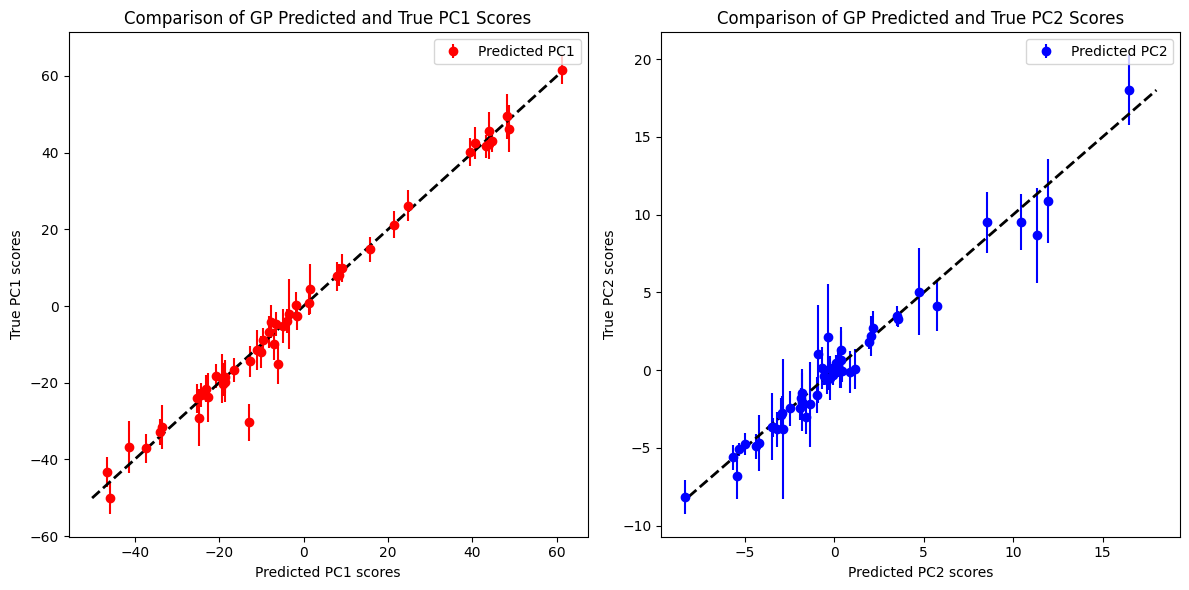

In [178]:
# Train models
# Initialize likelihood and model
likelihood1 = gpytorch.likelihoods.GaussianLikelihood()
likelihood1.noise_covar.noise = pca_noise[0]  # Set the noise level for PC1
model1 = GenericGPModel(X_train, y_train[:, 0], likelihood1)
train_model(model1, likelihood1, 50)

likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
likelihood2.noise_covar.noise = pca_noise[1]  # Set the noise level for PC2
model2 = GenericGPModel(X_train, y_train[:, 1], likelihood2)
train_model(model2, likelihood2, 50)

# Get into evaluation (predictive posterior) mode
model1.eval()
likelihood1.eval()
model2.eval()
likelihood2.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred1 = likelihood1(model1(X_test_tensor))
    observed_pred2 = likelihood2(model2(X_test_tensor))

# Calculate Q2 and LOOCV error
y_pred1 = observed_pred1.mean.numpy()
y_pred2 = observed_pred2.mean.numpy()

Q2_pc1 = r2_score(y_test[:, 0], y_pred1)
Q2_pc2 = r2_score(y_test[:, 1], y_pred2)

# Calculate MSE and variances
MSE_pc1 = ((y_test_tensor[:, 0] - observed_pred1.mean) ** 2).mean().item()
MSE_pc2 = ((y_test_tensor[:, 1] - observed_pred2.mean) ** 2).mean().item()

var_pc1 = observed_pred1.variance.mean().item()
var_pc2 = observed_pred2.variance.mean().item()

print(f"Q2 for PC1: {Q2_pc1}")
print(f"Q2 for PC2: {Q2_pc2}")
print(f"MSE for PC1: {MSE_pc1}")
print(f"MSE for PC2: {MSE_pc2}")
print(f"Variance for PC1: {var_pc1}")
print(f"Variance for PC2: {var_pc2}")

# Convert predictions back to numpy for plotting
y_pred1_np = y_pred1
y_pred2_np = y_pred2
y_test_np = y_test

# Calculate confidence intervals for visualization
confidence_interval_pc1 = 1.96 * observed_pred1.stddev.numpy()
confidence_interval_pc2 = 1.96 * observed_pred2.stddev.numpy()

# Plot for the first principal component with confidence intervals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.errorbar(y_pred1_np, y_test_np[:, 0], yerr=confidence_interval_pc1, fmt='o', color='r', label='Predicted PC1')
plt.plot([y_test_np[:, 0].min(), y_test_np[:, 0].max()],
         [y_test_np[:, 0].min(), y_test_np[:, 0].max()], 'k--', linewidth=2)
plt.xlabel('Predicted PC1 scores')
plt.ylabel('True PC1 scores')
plt.title('Comparison of GP Predicted and True PC1 Scores')
plt.legend()

# Plot for the second principal component with confidence intervals
plt.subplot(1, 2, 2)
plt.errorbar(y_pred2_np, y_test_np[:, 1], yerr=confidence_interval_pc2, fmt='o', color='b', label='Predicted PC2')
plt.plot([y_test_np[:, 1].min(), y_test_np[:, 1].max()],
         [y_test_np[:, 1].min(), y_test_np[:, 1].max()], 'k--', linewidth=2)
plt.xlabel('Predicted PC2 scores')
plt.ylabel('True PC2 scores')
plt.title('Comparison of GP Predicted and True PC2 Scores')
plt.legend()

plt.tight_layout()
plt.show()

## Impact of Measurement Data Uncertainty on GP Models

Incorporating a 5% measurement data uncertainty into the GP models has influenced the results in the following ways:

### Q2 (Coefficient of Determination)
- **PC1**: The Q2 for PC1 has slightly improved, indicating that the GP model for PC1 has become more accurate in explaining the variance in the test data.
- **PC2**: The Q2 for PC2 has remained relatively stable, suggesting that the model's explanatory power for PC2 has not significantly changed after accounting for the data uncertainty.

### Mean Squared Error (MSE)
- **PC1**: The MSE for PC1 has decreased significantly, which means that the predictions for PC1 are closer to the true values on average.
- **PC2**: The MSE for PC2 has also decreased slightly, indicating a marginal improvement in prediction accuracy for PC2.

### Variance of Predictions
- **PC1**: The variance of the predictions for PC1 has increased, reflecting the model's incorporation of the additional uncertainty from the data.
- **PC2**: The variance for PC2 has decreased slightly, which may be related to the specific characteristics of the PC2 scores and their relationship with the input features.

### Interpretation
The results suggest that the GP models are effectively incorporating the measurement data uncertainty, leading to more reliable predictions. The increased prediction variance for PC1 is a desirable feature in a well-calibrated model, as it represents a more honest reflection of the model's confidence in its predictions.

### Confidence Intervals
The confidence intervals in the plots should now be wider for PC1, indicating the increased uncertainty in the model's predictions. This provides a more accurate representation of the model's confidence and is beneficial for informed decision-making processes.

### Conclusion
By accounting for the measurement data uncertainty, the robustness of the GP models has been improved. The models now offer predictions with better accuracy and a more realistic estimate of the uncertainty associated with those predictions.